# Hands-on Deep Generative Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/landerlini/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)
[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/landerlini/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)
[![Open in GitHub](https://img.shields.io/badge/Open_in_GitHub-blue?style=flat&logo=github&logoColor=white&labelColor=555)](https://github.com/landerlini/mlinfn-advanced-hackathon/tutorial_gen_models.ipynb)

<div class="alert alert-block alert-info">
  <b>Authors:</b> M. Barbetti (INFN-CNAF), S. Capelli (INFN-MiB), F. Vaselli (INFN-Pisa)

  <b>Date created:</b> 30/10/2023
  
  <b>Last modified:</b> 02/11/2023

  <b>Description: </b> This hands-on demonstrates how deep generative models succeed in reproducing the high-level response of a generic HEP experiment, offering a viable solution to reduce the pressure on the computing budget for simulation production. In particular, in this notebook we will test the performance of Generative Adversarial Networks and Normalizing Flows to parameterize the errors introduced during the detection and reconstruction of high-energy particle jets using the CMS detector.
</div>

## Introduction

### What is CMS?

The Compact Muon Solenoid (CMS) experiment is a key research project at the Large Hadron Collider (LHC) at CERN. It's a particle physics detector that observes and measures the byproducts of high-energy particle collisions in the LHC. CMS is designed to investigate a wide range of physics phenomena, and it played a pivotal role in the discovery of the Higgs boson in 2012.

CMS is a general-purpose detector, meaning it's equipped to study various aspects of particle physics. Its main components include a superconducting solenoid magnet, various particle detectors, and systems for tracking, energy measurement, and muon detection. This sophisticated setup allows scientists to explore several key questions in fundamental physics, such as the properties of the Higgs boson, the search for supersymmetry, the nature of dark matter, and potential evidence of extra dimensions.

#### Measuring jets at CMS

In CMS, particle jets are crucial for understanding high-energy processes. They are sprays of particles formed when quarks and gluons, produced in high-energy collisions like those at the LHC, 'hadronize' or turn into ordinary matter. By analyzing the jets' energy and momentum, physicists can infer properties of the original particles, helping in studies like proton structure, the strong force, and new physics beyond the Standard Model.

<div align="center">
  <img src="https://cms.cern/sites/default/files/field/image/Sketch_PartonParticleCaloJet.png" width="800"/>
</div>

### What are Deep Generative Models?

TBA (a few word about DGM)

#### Generative Adversarial Networks

Generative Adversarial Networks [[1][1]] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  **Discriminator network** ($D$) - trained by a classification task to separate the generator output from the reference dataset
* **Generator network** ($G$) - trained by a simulation task to reproduce the reference dataset trying to fake the discriminator

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1][1]].

[1]: https://arxiv.org/abs/1406.2661

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/pidgan-notebooks/main/.github/images/gan-scheme.png" width="800"/>
</div>

##### Additional details

Traditional GAN systems suffer from many issues, particularly during the training phase:

* the generator may _collapse_ producing only a single sample or a small family of very similar samples (**mode collapse**)
* the two players may _oscillate_ during training rather than converging to the [**Nash equilibrium**](https://en.wikipedia.org/wiki/Nash_equilibrium)
* if _imbalance_ between the two players occurs, then the system is incapable of learning at all

All these drawbacks result from the [**vanishing gradient problem**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), namely the lack of information for the update of the $G$ parameters. This is due to the saturation of the $D$ that is so good in distinguishing the origin of the two samples that no errors remain to the $G$ to improve the generated space [[2][2]]. To fix such problem, the typical solution proposed by the literature is to change the loss function that drive the training procedure [[3][3], [4][4]], to force the smoothness of the discriminator response to the classification task [[5][5], [6][6], [7][7]], or to adoopt a set of strategies in the architecture of the two players [[8][8]]. Each of these solutions can be easily implemented through [pidgan](https://github.com/mbarbetti/pidgan), a Python package designed to simplify the provisioning of GAN-based models to flash-simulate the LHCb experiment.

[2]: https://arxiv.org/abs/1701.04862
[3]: https://arxiv.org/abs/1611.04076
[4]: https://arxiv.org/abs/1701.07875
[5]: https://arxiv.org/abs/1704.00028
[6]: https://arxiv.org/abs/1705.10743
[7]: https://arxiv.org/abs/1907.05681
[8]: https://arxiv.org/abs/1606.03498
[9]: https://arxiv.org/abs/1411.1784

#### Normalizing Flows

GANs do not explicitly learn $p(\mathbf{x})$, the probability density function of real data--it can be really hard to! Taking the generative model with latent variables as an example, $p(\mathbf{x}) = \int p(\mathbf{x}\vert\mathbf{z})p(\mathbf{z})d\mathbf{z}$ can hardly be calculated as it is intractable to go through all possible values of the latent code.

Flow-based deep generative models conquer this hard problem with the help of normalizing flows, a powerful statistics tool for density estimation. A good estimation of $p(\mathbf{x})$ makes it possible to efficiently complete many downstream tasks: sample unobserved but realistic new data points (**data generation**), predict the rareness of future events (density estimation), infer latent variables, fill in incomplete data samples, etc.

Here comes a Normalizing Flow (NF) model for better and more powerful distribution approximation. A normalizing flow transforms a simple distribution into a complex one by applying a sequence of invertible transformation functions. Flowing through a chain of transformations, we repeatedly substitute the variable for the new one according to the change of variables theorem and eventually obtain a probability distribution of the final target variable. During training we learn $z=f(x)$ sending data into the Gaussian space, then we can invert $f$ to get new samples $\hat{x}= f^{-1}(z)$.

<div align="center">
  <img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" width="800"/>
</div>

## Hands-on generative models with CMS data

General Simulation Steps in CMS and HEP

In High Energy Physics (HEP), simulations are crucial for understanding the outcomes of particle collisions, like those observed in the CMS experiment. The general simulation process involves several steps:

    -Event Generation: Simulating the initial high-energy collision and the primary processes that follow.
    -Particle Tracking and Interaction: Simulating how the particles produced in the collision travel through and interact with the detector material.
    -Detector Response: Modeling how the detector responds to these particles.
    -Data Reconstruction (Reco-Level): Processing the simulated detector signals to reconstruct what happened in the collision.

These steps are computationally expensive due to the complex physics involved and the high precision required. Each collision can produce a multitude of particles, making the simulation of even a single event a resource-intensive task.
Advantages of Using ML

Machine Learning (ML) can significantly speed up this process, particularly the reconstruction phase. By training models to emulate the behavior of particles in the detector and their interaction, we can bypass the need for detailed, step-by-step simulation, reducing computation time and resource usage.

In this exercise, we aim to simulate reconstruction-level (reco-level) jets from generator-level (gen-level) data. We have prepared Ntuple numpy arrays for about 1,000,000 pairs of genjets and their associated recojets from with Pythia. These numpy arrays are essentially large datasets containing features of both genjets and recojets.

**Problem Statement**: Learn to generate the features of recojets given the values of the associated genjet features. This exercise will involve predicting the properties of the recojets (like momentum, eta, etc.) based on the known properties of the genjets.

### Setup

Initial setup for your ML-INFN instance (not needed if you are running on Colab or Kaggle).

**Note:** If you plan to run this notebook live during the hands-on, we suggest to set `True` the variable `LIVE` in order to limit the execution time of the whole notebook to about 30 minutes.

In [18]:
LIVE = True

import os, subprocess, re
os.environ["CUDA_VISIBLE_DEVICES"] = "".join(
  re.findall(
    "UUID: (MIG-[^)]+)\)",
    str(subprocess.check_output(["nvidia-smi", "-L"]), "ascii")
  )
)

### Prerequisites

The first step is to import the main packages of this hands-on, namely [pidgan](https://github.com/mbarbetti/pidgan) and [nflows](https://github.com/bayesiains/nflows). If you are running out of the provided ML-INFN instances (like Colab or Kaggle), before to run the following code cells, you need to install the both the packages and some other ones that are typically needed in machine learning applications to HEP (i.e., uproot, scipy, scikit-learn, matplotlib). This can be done adding a new code cell containing what follows:

```
%%capture
!pip install pidgan[hep] nflows corner
```

Let's verify the correct installation of [pidgan](https://github.com/mbarbetti/pidgan) printing its version:

In [2]:
import pidgan

pidgan.__version__

'0.0.7'

Since [pidgan](https://github.com/mbarbetti/pidgan) relies on TensorFlow and Keras as backends, we also need to verify the correct installation of TensorFlow checking that it is able to assess and run on the equipped GPU (if any):

In [3]:
import tensorflow as tf

avail_gpus = tf.config.list_physical_devices("GPU")
avail_gpus  # outputs a non-empty list in case of GPU equipped

2023-11-02 12:43:44.853086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 12:43:45.643289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]

Now, let's verify the correct installation of [nflows](https://github.com/bayesiains/nflows) printing its version:

In [4]:
import nflows

nflows.__version__

Since [nflows](https://github.com/bayesiains/nflows) relies on PyTroch as backend, we also need to verify the correct installation of PyTorch checking that it is able to assess and run on the equipped GPU (if any):

In [5]:
import torch

torch.cuda.init()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

rnd = torch.randn((100, 1)).to(device)

Finally, we just have to import all the modules that we will use in the following code cells:

In [6]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler, LabelEncoder, OneHotEncoder

from .utils import plot_histograms_and_ratios, make_corner

### Data loading and preparation

The data needed for this hands-on is provided within the `data` folder as a root file (`'cms_data.root'`). The dataset contains about 1.2M instances, 5 input features and 5 output features. Let's import the data as a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [7]:
with uproot.open("./data/cms_data.root") as file:
  data = file["recojet"].arrays(library="pd").drop("index", axis=1)

data.describe()

,pT,eta,phi,E,flavour,reco_pT,reco_eta,reco_phi,reco_nConstituents,b_tag
count,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06,1.173006e+06
mean,5.774316e+01,-3.606635e-03,3.142674e+00,1.820326e+02,-1.751057e-03,5.823546e+01,-3.583049e-03,3.142717e+00,1.772764e+01,3.891182e-01
std,4.740463e+01,1.698428e+00,1.813134e+00,2.612149e+02,2.957189e+00,4.954559e+01,1.698818e+00,1.813508e+00,8.978564e+00,3.799157e-01
min,1.500001e+01,-6.247127e+00,1.370349e-06,1.511571e+01,-5.000000e+00,-2.736475e+00,-6.225502e+00,1.377906e-06,0.000000e+00,3.145769e-05
25%,2.606500e+01,-1.156958e+00,1.575168e+00,5.171500e+01,0.000000e+00,2.604108e+01,-1.156651e+00,1.574912e+00,1.100000e+01,5.980294e-02
50%,4.404862e+01,-4.191196e-03,3.141528e+00,9.736305e+01,0.000000e+00,4.390334e+01,-4.189691e-03,3.141232e+00,1.600000e+01,1.744231e-01
75%,7.374522e+01,1.150521e+00,4.711539e+00,1.969485e+02,0.000000e+00,7.428231e+01,1.150217e+00,4.712032e+00,2.300000e+01,8.527536e-01
max,1.568434e+03,6.298655e+00,6.283185e+00,5.069652e+03,5.000000e+00,1.915857e+03,6.525997e+00,6.533353e+00,1.100000e+02,9.999949e-01


**Note:** If you are running out of the provided ML-INFN instances (like Colab or Kaggle), a reduced version of the original dataset is available through a CSV file and can be imported as a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) using the following code lines:

```python
url = "https://raw.githubusercontent.com/landerlini/mlinfn-advanced-hackathon/main/generative_models/data/cms_data_reduced.csv"
data = pd.read_csv(url)
```

TBA (add some information about the input features)

Gen-level info:
* `data.pT` - transverse momentum $p_T$ in GeV/$c$ of the jet
* `data.eta` - pseudorapidity $\eta$ of the jet
* `data.phi` - angle $\varphi$ in the x-y plane of the jet
* `data.E` - energy $E$ in GeV of the jet
* `data.flavour` - flavour of the jet (-6: $\bar{b}$, -4: $\bar{c}$, 0: $g$, 4: $c$)

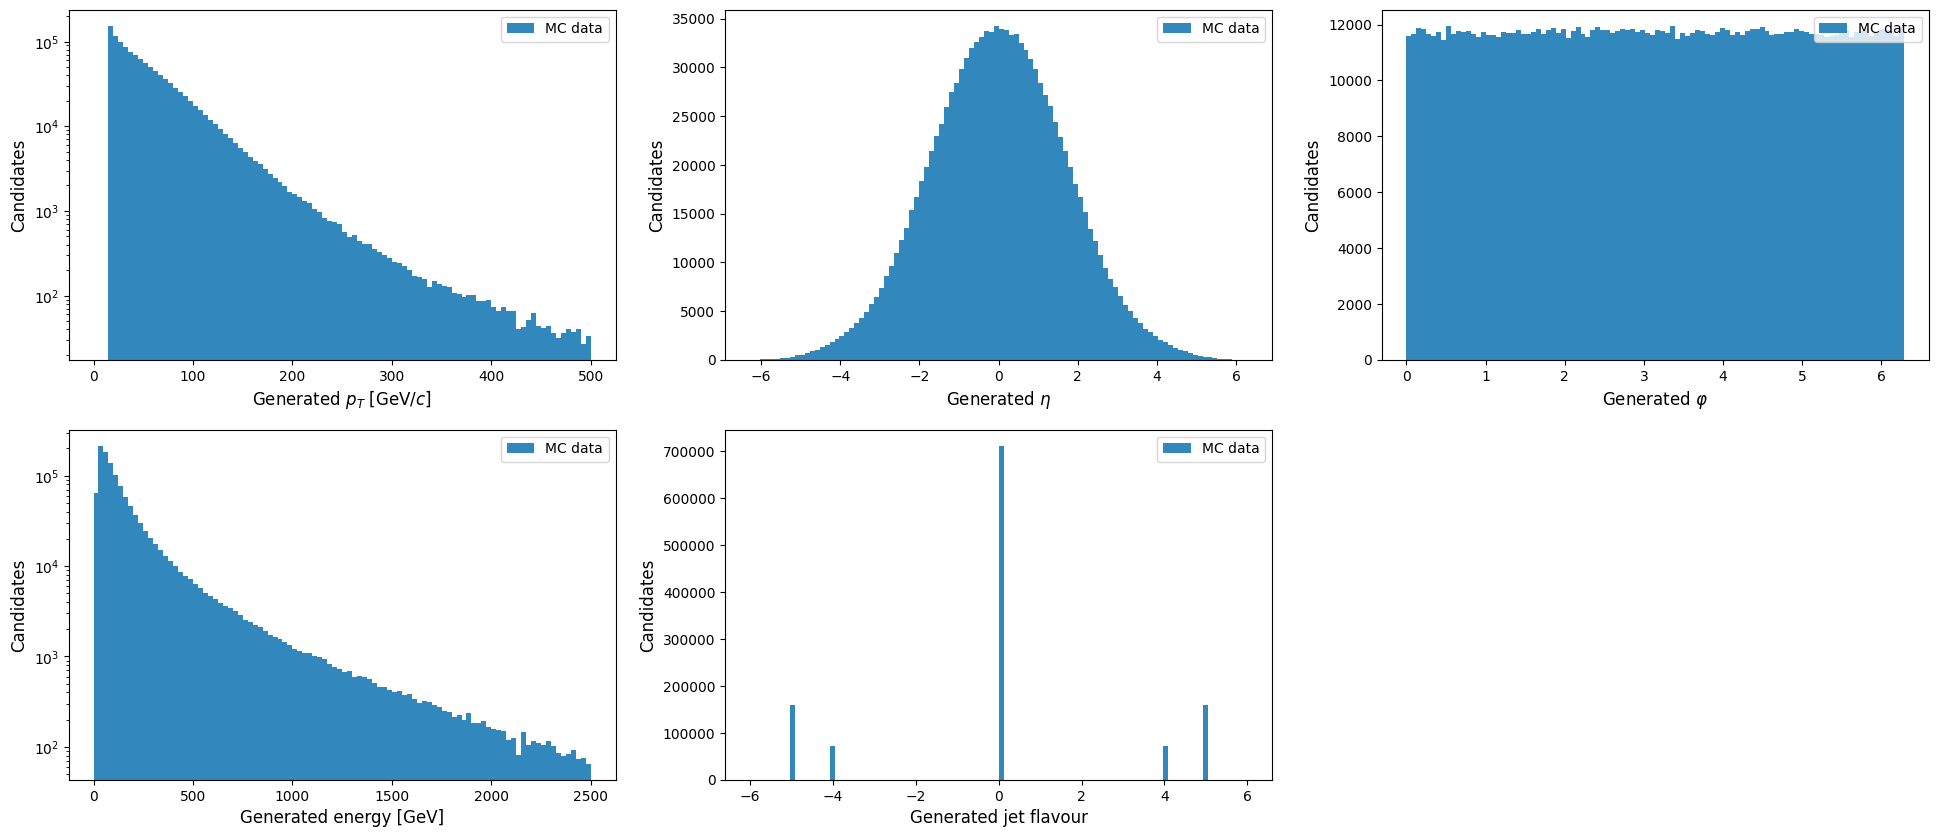

In [16]:
plt.figure(figsize=(24, 10))

plt.subplot(2, 3, 1)
plt.xlabel("Generated $p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["pT"], bins=np.linspace(0.0, 500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 3, 2)
plt.xlabel(r"Generated $\eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["eta"], bins=np.linspace(-2*np.pi, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 3)
plt.xlabel(r"Generated $\varphi$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["phi"], bins=np.linspace(0.0, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 4)
plt.xlabel("Generated energy [GeV]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["E"], bins=np.linspace(0.0, 2500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 3, 5)
plt.xlabel("Generated jet flavour", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["flavour"], bins=np.linspace(-6.0, 6.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

TBA (add some information about the output features)

Reco-level info:
* `data.reco_pT` - reconstructed transverse momentum $p_T$ in GeV/$c$ of the jet
* `data.reco_eta` - reconstructed pseudorapidity $\eta$ of the jet
* `data.reco_phi` - reconstructed angle $\varphi$ in the x-y plane of the jet
* `data.reco_nConstituents` - reconstructed number of particles within the jet
* `data.b_tag` - TBA (add description)

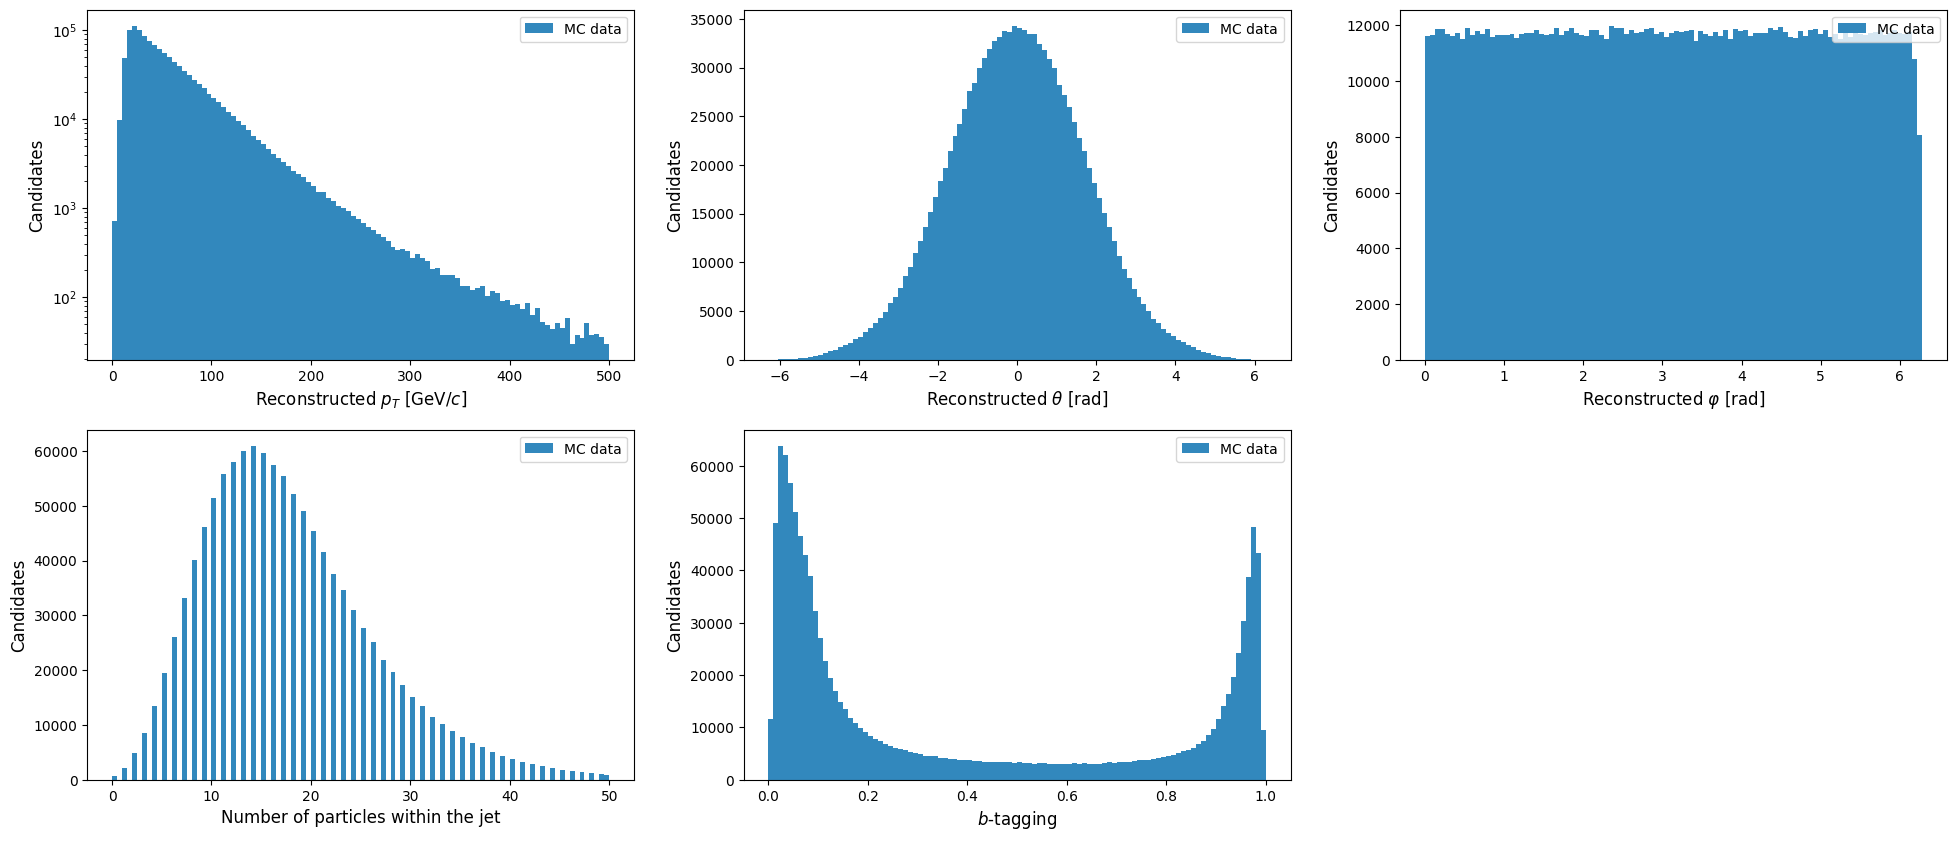

In [17]:
plt.figure(figsize=(24, 10))

plt.subplot(2, 3, 1)
plt.xlabel("Reconstructed $p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_pT"], bins=np.linspace(0.0, 500.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(2, 3, 2)
plt.xlabel(r"Reconstructed $\eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_eta"], bins=np.linspace(-2*np.pi, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 3)
plt.xlabel(r"Reconstructed $\varphi$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_phi"], bins=np.linspace(0.0, 2*np.pi, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 4)
plt.xlabel("Number of particles within the jet", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["reco_nConstituents"], bins=np.linspace(0.0, 50.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 5)
plt.xlabel("$b$-tagging", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(data["b_tag"], bins=np.linspace(0.0, 1.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

As usual in a machine learning application, the data sample is split into **training** and **test set**.

In [19]:
data = shuffle(data)

chunk_size = -1 if not LIVE else 500000
data = data[:chunk_size]

x_vars = ["pT", "eta", "phi", "E", "flavour"]
x = data[x_vars].values

y_vars = ["reco_pT", "reco_eta", "reco_phi", "reco_nConstituents", "b_tag"]
y = data[y_vars].values

train_ratio = 0.7
train_size = int(train_ratio * len(data))

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"x_train shape: {x_train.shape} \t x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}")

x_train shape: (350000, 5) 	 x_test shape: (150000, 5)
y_train shape: (350000, 5) 	 y_test shape: (150000, 5)


### Generative Adversarial Networks

#### Data preprocessing

To normalize the different ranges and orders of magnitude of input $x$ and output $y$ features highlighted by the previous histograms, we will use the scikit-learn [`QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) and [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) preprocessing operators.

Since one of the $x$ features is categorical (`data.flavour`), the latter should be kept unchanged by the preprocessing operators and transformed through a [**one-hot**](https://en.wikipedia.org/wiki/One-hot) encoder.

If we want to combine together different preprocessing operators in one go, we can use the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) class by scikit-learn.

In [20]:
x_scaler = ColumnTransformer(
  [
    ("quantile", QuantileTransformer(output_distribution="normal"), (0, 3)),  # pT, E
    ("standard", StandardScaler(), (1, 2)),  # theta, phi
  ]
)
x_train_prep = x_scaler.fit_transform(x_train[:, :-1])  # except 'flavour' column

pd.DataFrame(x_train_prep, columns=["pT", "E", "eta", "phi"]).describe()

,pT,E,eta,phi
count,350000.000000,350000.000000,3.500000e+05,3.500000e+05
mean,0.023188,-0.014886,2.225014e-17,-1.682159e-16
std,1.010150,0.999955,1.000001e+00,1.000001e+00
min,-5.199338,-5.199338,-3.603261e+00,-1.734827e+00
25%,-0.652855,-0.679197,-6.798753e-01,-8.639977e-01
50%,0.032798,-0.013585,-1.070838e-03,-8.299841e-04
75%,0.724138,0.660239,6.784841e-01,8.648250e-01
max,5.199338,5.199338,3.710937e+00,1.732655e+00


In [21]:
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(x_train[:, -1])  # 'flavour' column

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(int_encoded[:, None])  # one-hot encoding

x_train_prep = np.concatenate([x_train_prep, onehot_encoded], axis=1)
x_train_prep.shape

(350000, 9)

Since most of the output $y$ features are the reconstructed version of the input $x$ features, we should build a model able to reproduce only the **errors** introduced in the detection and reconstruction steps instead of directly parameterize the reconstruction algorithms. This _regularizes_ the training procedure and may simplify any debugging campaign.

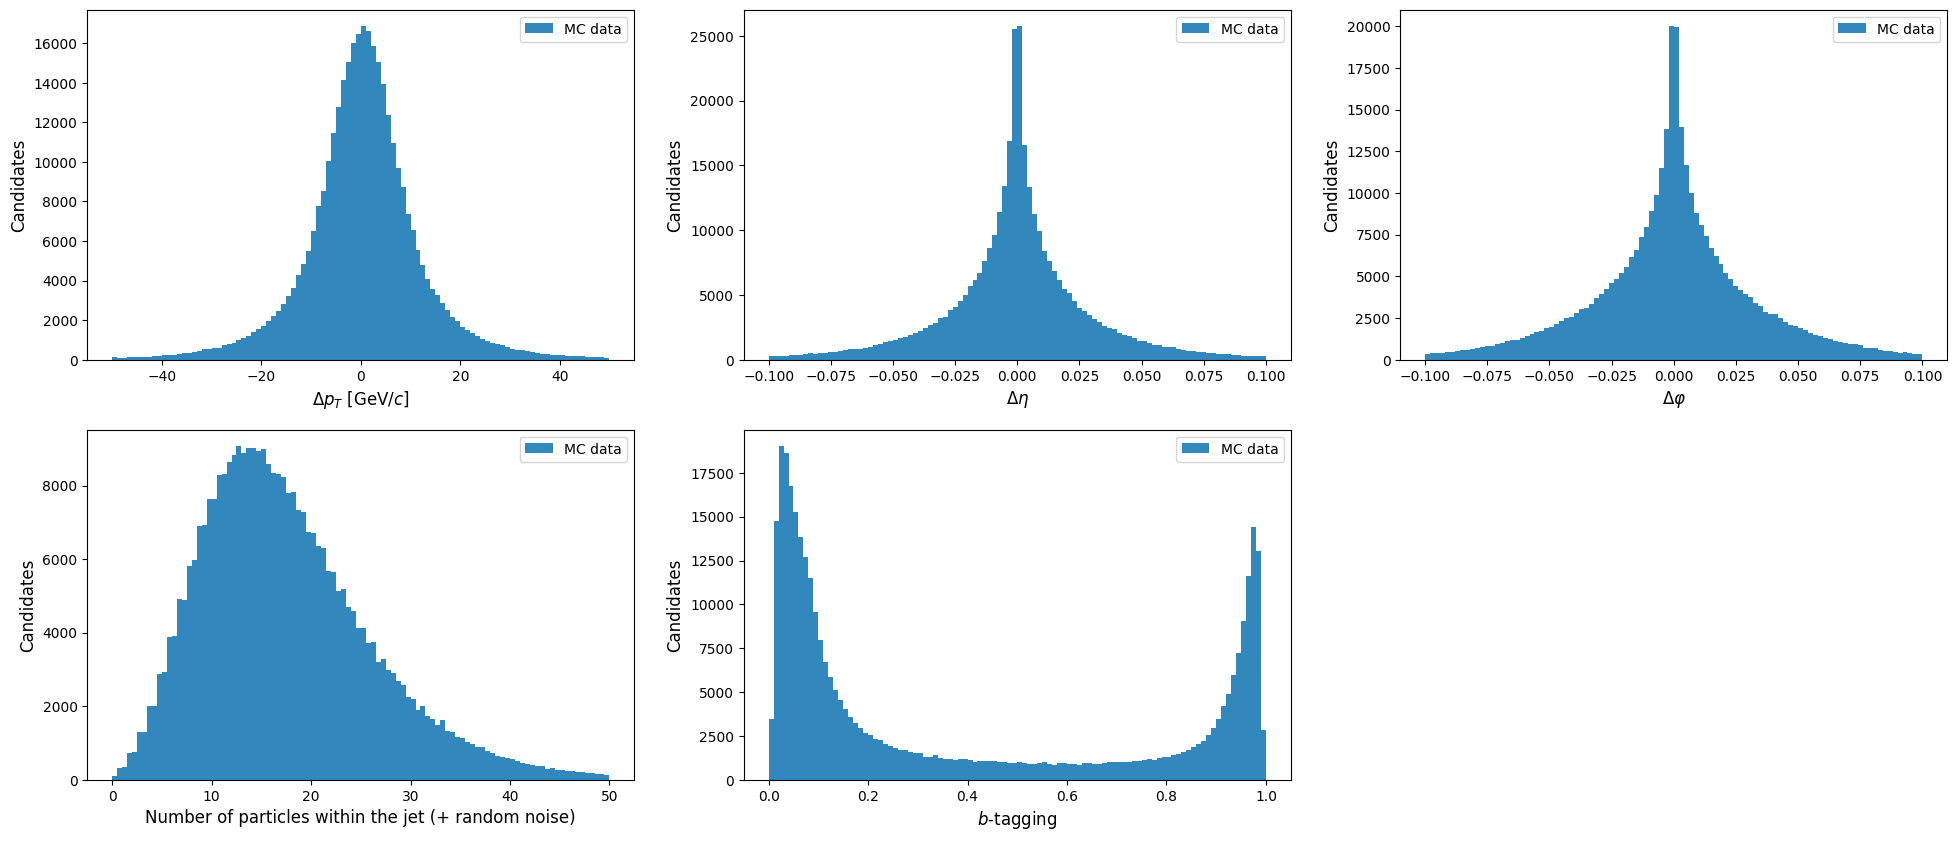

In [23]:
y_train_prep = y_train.copy()
y_train_prep[:, :3] -= x_train[:, :3]
y_train_prep[:, 3] += np.random.uniform(-0.5, 0.5, size=(len(y_train),))  # 'reco_nConstituents' from discrete to continous

plt.figure(figsize=(24, 10))

plt.subplot(2, 3, 1)
plt.xlabel("$\Delta p_T$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 0], bins=np.linspace(-50.0, 50.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 2)
plt.xlabel(r"$\Delta \eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 1], bins=np.linspace(-0.1, 0.1, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 3)
plt.xlabel(r"$\Delta \varphi$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 2], bins=np.linspace(-0.1, 0.1, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 4)
plt.xlabel("Number of particles within the jet (+ random noise)", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 3], bins=np.linspace(0.0, 50.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(2, 3, 5)
plt.xlabel("$b$-tagging", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_train_prep[:, 4], bins=np.linspace(0.0, 1.0, 101), color="#3288bd", label="MC data")
plt.legend(loc="upper right", fontsize=10)

plt.show()

In [24]:
y_scaler = QuantileTransformer(output_distribution="normal")
y_train_prep = y_scaler.fit_transform(y_train_prep)

pd.DataFrame(y_train_prep, columns=y_vars).describe()

,reco_pT,reco_eta,reco_phi,reco_nConstituents,b_tag
count,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000
mean,0.001909,-0.007108,-0.006793,0.007945,0.002371
std,1.008803,0.992114,1.001646,0.992979,0.996115
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.674891,-0.681519,-0.690091,-0.655995,-0.664410
50%,0.009141,-0.016969,-0.017096,0.009456,0.013788
75%,0.676057,0.660198,0.672903,0.668915,0.670762
max,5.199338,5.199338,5.199338,5.199338,5.199338


#### Package presentation

Implementing a GAN in TensorFlow is straightforward, even if becoming familiar with the various tricks to stabilize the training procedure or moving from a GAN flavour to another may be non-trivial. The aim of this hands-on is to prove the effectiveness of generative models for HEP simulations, hence we will rely on [pidgan](https://github.com/mbarbetti/pidgan) for the GAN implementations. Such Python package has been designed in the context of LHCb flash-simulation and offers a wide set of GAN algorithms implemented customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class.

| Algorithms* | Lipschitzianity** | Design inspired by | Tutorial |
|:-----------:|:-----------------:|:------------------:|:--------:|
| [`GAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/GAN.py) | ❌ | [1][1], [2][2], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-GAN-LHCb_RICH.ipynb) |
| [`BceGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN.py) | ❌ | [1][1], [2][2], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-BceGAN-LHCb_RICH.ipynb) |
| [`LSGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/LSGAN.py) | ❌ | [3][3], [2][2], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-LSGAN-LHCb_RICH.ipynb) |
| [`WGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN.py) | ✅ | [4][4], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-WGAN-LHCb_RICH.ipynb) |
| [`WGAN_GP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_GP.py) | ✅ | [5][5], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-WGAN_GP-LHCb_RICH.ipynb) |
| [`CramerGAN`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/CramerGAN.py) | ✅ | [6][6], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-CramerGAN-LHCb_RICH.ipynb) |
| [`WGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/WGAN_ALP.py) | ✅ | [7][7], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-WGAN_ALP-LHCb_RICH.ipynb) |
| [`BceGAN_GP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN_GP.py) | ✅ | [1][1], [5][5], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-BceGAN_GP-LHCb_RICH.ipynb) |
| [`BceGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN_ALP.py) | ✅ | [1][1], [7][7], [8][8] | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/pidgan-notebooks/blob/main/tutorial-BceGAN_ALP-LHCb_RICH.ipynb) |

*each GAN algorithm is designed to operate taking __conditions__ as input [[9][9]]

**the GAN training is regularized to ensure that the discriminator encodes a 1-Lipschitz function

Training a GAN system corresponds to perform a competition, namely the **minimax game**, between the generator and discriminator networks. The latters are provided by the [pidgan](https://github.com/mbarbetti/pidgan) package through the [`players`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/players) module that implements the two networks via custom TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)s.

[1]: https://arxiv.org/abs/1406.2661
[2]: https://arxiv.org/abs/1701.04862
[3]: https://arxiv.org/abs/1611.04076
[4]: https://arxiv.org/abs/1701.07875
[5]: https://arxiv.org/abs/1704.00028
[6]: https://arxiv.org/abs/1705.10743
[7]: https://arxiv.org/abs/1907.05681
[8]: https://arxiv.org/abs/1606.03498
[9]: https://arxiv.org/abs/1411.1784

#### The generator

The **generator player** can be implemented with the high-level [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Before to initialize a `Generator` instance, let's have a look at its arguments:

* **`output_dim`** (_int_) - Dimensionality of the generator output space.
* **`latent_dim`** (_int_) - Dimensionality of the latent space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default=None) - Activation function to use in the generator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the generator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the generator layer computations and weights.

In [25]:
from pidgan.players.generators import Generator

generator = Generator(
    output_dim=y_train_prep.shape[-1],
    latent_dim=64,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="generator"
)

In [26]:
_ = generator(keras.Input(shape=x_train_prep.shape[1:]))
generator.summary()

Model: "generator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               9472      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)             

#### The discriminator

The **discriminator player** can be implemented with the high-level [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) class that provides the neural network model wrapping the TensorFlow [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). Again, before to initialize a `Discriminator` instance, let's have a look to its arguments:

* **`output_dim`** (_int_) - Dimensionality of the discriminator output space.
* **`num_hidden_layers`** (_int_, default=5) - Number of the hidden layers passed to the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. Each hidden layer has a LeakyReLU as activation function (see [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)).
* **`mlp_hidden_units`** (_int_ or _array_like_, default=128) - Number of neuron units per each hidden layer. It can also be passed as an array of unit numbers having length equal to the number of hidden layers.
* **`mlp_dropout_rates`** (_float_ or _array_like_, default=0.0) - Fraction of the input neurons to drop per each hidden layer. It can also be passed as an array of float numbers having length equal to the number of hidden layers.
* **`output_activation`** (_activation_like_ or _None_, default="sigmoid") - Activation function to use in the dicriminator output layer (see [`tf.keras.activations`](https://www.tensorflow.org/api_docs/python/tf/keras/activations)). If None, no activation is applied (i.e., "linear" activation: $a(x) = x$).
* **`name`** (_str_ of _None_, default=None) - The name of the discriminator model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the discriminator layer computations and weights.

In [27]:
from pidgan.players.discriminators import Discriminator

discriminator = Discriminator(
    output_dim=1,
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="discriminator"
)

In [28]:
_ = discriminator((keras.Input(shape=x_train_prep.shape[1:]), keras.Input(shape=y_train_prep.shape[1:])))
discriminator.summary()

Model: "discriminator_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 128)               1920      
                                                                 
 leaky_relu_0 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_0 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)         

#### The GAN algorithm

The **BceGAN-ALP algorithm** [[1][1], [5][5]] can be implemented with the high-level [`BceGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN_ALP.py) class that defines the training procedure of the two players customizing the TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class and, in particular, its `fit()` method. Once again, before to initialize a `BceGAN_ALP` instance, let's have a look at its arguments:

* **`generator`** (_generator_like_) - The generator network. It must be passed as a pidgan [`Generator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/generators/Generator.py) instance.
* **`discriminator`** (_discriminator_like_) - The discriminator network. It must be passed as a pidgan [`Discriminator`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/discriminators/Discriminator.py) instance.
* **`lipschitz_penalty`** (_float_, default=1.0) - Importance of the regularization term GP that implicitly constrains the discriminator to induce a 1-Lipschitz function as proposed in Ref. [[4][4]].
* **`lipschitz_penalty_strategy`** (_str_, default="one-sided") - If "two-sided" is passed, the Lipschitz constant computed along the virtual adversarial direction is forced to be equal to 1. When "one-sided" is preferred, only Lipschitz constant values greater than 1 are penalized.
* **`feature_matching_penalty`** (_float_, default=0.0) - Importance of the regularization term added to the generator training to force the hidden state of the discriminator to match between reference and generated examples. Its design follows from what proposed in Ref. [[8][8]].
* **`referee`** (_classifier_like_ or _None_, default=None) - When passed it enables the training of a third independent player: the referee network. It can be used to assess the quality of the generator output during the training. If passed, it must be a pidgan [`Classifier`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/players/classifiers/Classifier.py) instance.
* **`name`** (_str_ or _None_, default="BceGAN_ALP") - The name of the BceGAN-ALP model.
* **`dtype`** (_dtype_ or _None_, default=None) - The dtype of the BceGAN-ALP model computations.

[1]: https://arxiv.org/abs/1406.2661
[5]: https://arxiv.org/abs/1704.00028
[8]: https://arxiv.org/abs/1606.03498

To not further complicate this tutorial, we avoid to use the referee network in this case, even if its initialization is straightforward:

```python
from pidgan.players.classifiers import Classifier

referee = Classifier(
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    name="referee"
)
```

It's time to initialize a [`BceGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN_ALP.py) instance!

In [29]:
from pidgan.algorithms import BceGAN_ALP

gan = BceGAN_ALP(
    generator=generator,
    discriminator=discriminator,
    lipschitz_penalty=1.0,
    lipschitz_penalty_strategy="one-sided",
    feature_matching_penalty=0.0,
    referee=None,
    name="BceGAN_ALP",
)

#### Model compilation

To finalize the [`BceGAN_ALP`](https://github.com/mbarbetti/pidgan/blob/main/src/pidgan/algorithms/BceGAN_ALP.py) model preparation before to run the training procedure, we need to execute the `compile()` method. Differently from the TensorFlow `compile()` method, the [pidgan](https://github.com/mbarbetti/pidgan) one doesn't require to pass the loss function since it is encoded in the customized `gan.fit()` method. The arguments of the `gan.compile()` method follows:

* **`metrics`** (_list_ or _None_, default=None) - If not None, list of metrics to be evaluated by the BceGAN-GP model during training and testing. Each of this can be a string (name of a built-in pidgan function) or a [`pidgan.metrics`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/metrics) instance.
* **`generator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the generator network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`discriminator_optimizer`** (_optimizer_like_, default="rmsprop") - String (name of optimizer) or optimizer instance for the discriminator network. (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`generator_upds_per_batch`** (_int_, default=1) - Number of the generator weights updates per batch of data.
* **`discriminator_upds_per_batch`** (_int_, default=1) - Number of the discriminator weights updates per batch of data.
* **`virtual_adv_direction_upds`** (_int_, default=1) - Number of iterations to approximate the virtual adversarial direction per discriminator update as proposed in Ref. [[4][4]].
* **`referee_optimizer`** (_optimizer_like_ or _None_, default=None) - If not None, string (name of optimizer) or optimizer instance for the referee network (see [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)).
* **`referee_upds_per_batch`** (_int_ or _None_, default=None) - If not None, number of the referee weights updates per batch of data.

[4]: https://arxiv.org/abs/1907.05681

In [30]:
gan.compile(
    metrics=["wass_dist"],  # Wasserstein distance
    generator_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    discriminator_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    virtual_adv_direction_upds=1,
    referee_optimizer=None,
    referee_upds_per_batch=None,
)

The [pidgan](https://github.com/mbarbetti/pidgan) package provides several learning rate scheduling strategies through the [`callbacks.schedulers`](https://github.com/mbarbetti/pidgan/tree/main/src/pidgan/callbacks/schedulers) module. The pidgan schedulers are designed as [custom TensorFlow callbacks](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks) that also allow to trace the learning rate value of each passed optimizer during the training. In this tutorial, we will use an exponential decay schedule both for the generator and discriminator networks:

<center>$\eta(t) = \eta_0 \cdot e^{- \alpha \cdot t / \tau}$</center>

where $\eta(t)$ indicates the learning rate value at a specific training step $t$, $\eta_0$ the initial learning rate, $\alpha$ the decay rate and $\tau$ the decay step.

In [31]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

schedules = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=75000,
    min_learning_rate=1e-6,
    verbose=True,
    key="g_lr",
)
schedules.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=50000,
    min_learning_rate=1e-6,
    verbose=True,
    key="d_lr",
)
schedules.append(d_lr_sched)

Calling `gan.fit()` allows to perform the **minimax two-player game**, training the generator to reproduce the reference space $y$ on the basis of the conditions $x$ thanks to the discriminator feedbacks. The arguments taken by the pidgan `fit()` method are the same ones traditionally passed to a TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) instance. The schedulers are passed through the `callbacks` argument and, since their verbosity has been enabled (`verbose` and `key` passed), the learning rates of both the generator and discriminator are printed during the training procedure.

In [32]:
start = datetime.now()

train = gan.fit(
    x=x_train_prep,
    y=y_train_prep,
    batch_size=256,
    epochs=250 if not LIVE else 50,
    validation_split=0.3,
    callbacks=schedules,
    verbose=1,
)

stop = datetime.now()

print(f"Training procedure completed in {stop - start}")

Epoch 1/100
958/958 [==============================] - 14s 12ms/step - g_loss: 0.7470 - d_loss: 0.6881 - wass_dist: -0.0082 - g_lr: 9.8544e-04 - d_lr: 9.7826e-04 - val_g_loss: 0.6920 - val_d_loss: 0.6927 - val_wass_dist: -0.0049
Epoch 2/100
958/958 [==============================] - 11s 11ms/step - g_loss: 0.6958 - d_loss: 0.6932 - wass_dist: -0.0241 - g_lr: 9.5688e-04 - d_lr: 9.3604e-04 - val_g_loss: 0.7015 - val_d_loss: 0.6919 - val_wass_dist: -0.0015
Epoch 3/100
958/958 [==============================] - 11s 11ms/step - g_loss: 0.6993 - d_loss: 0.6923 - wass_dist: -0.0719 - g_lr: 9.2914e-04 - d_lr: 8.9564e-04 - val_g_loss: 0.6931 - val_d_loss: 0.6921 - val_wass_dist: -0.0144
Epoch 4/100
958/958 [==============================] - 11s 11ms/step - g_loss: 0.7039 - d_loss: 0.6911 - wass_dist: -0.0090 - g_lr: 9.0221e-04 - d_lr: 8.5699e-04 - val_g_loss: 0.7038 - val_d_loss: 0.6837 - val_wass_dist: -0.0272
Epoch 5/100
958/958 [==============================] - 11s 11ms/step - g_loss: 0.711

The following code cells report the **learning** and **metric curves** for the training just finished.

#### Learning curves

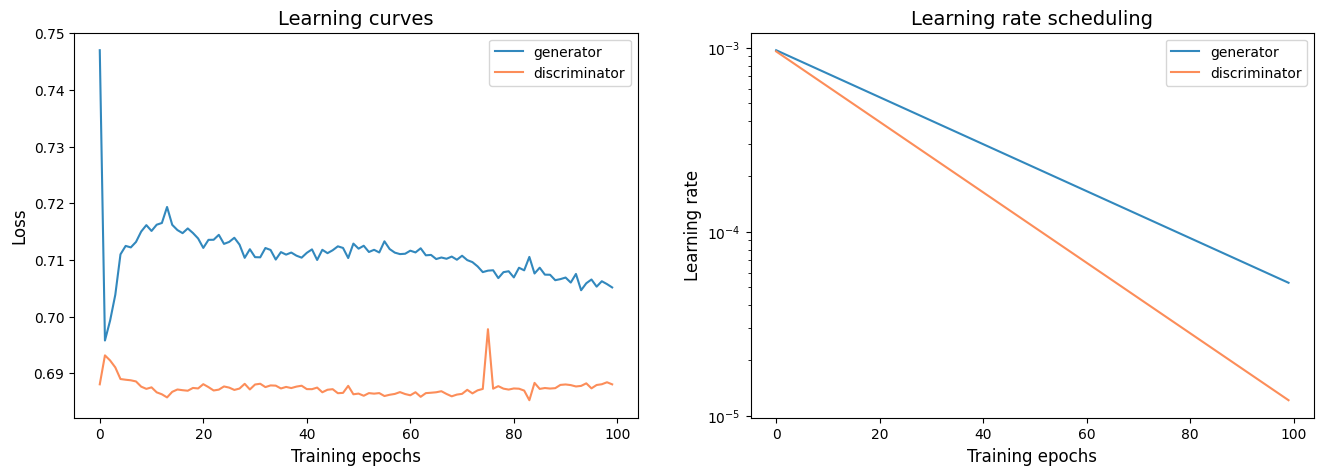

In [33]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

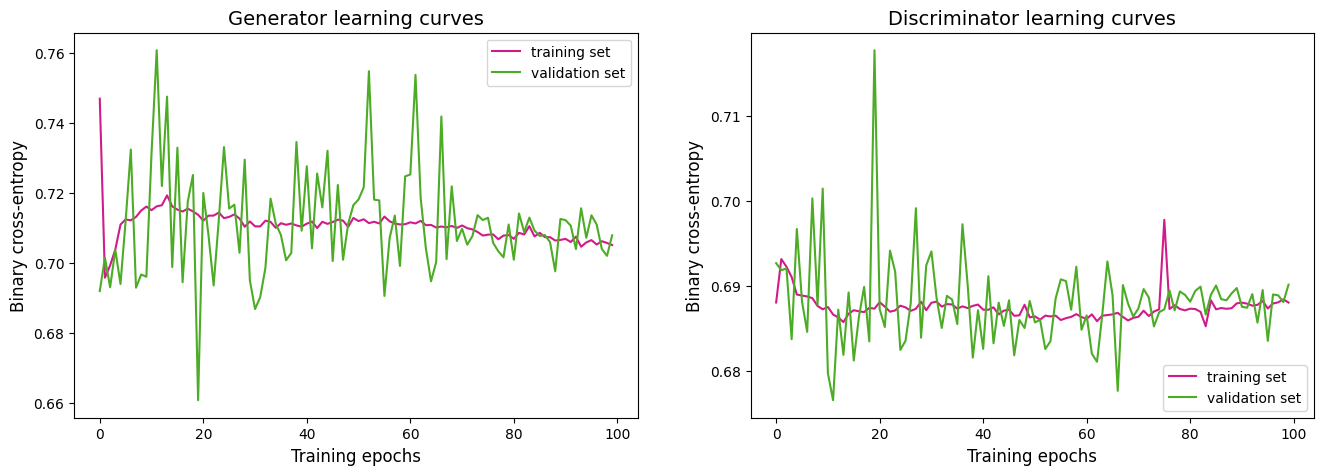

In [34]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

#### Metric curves

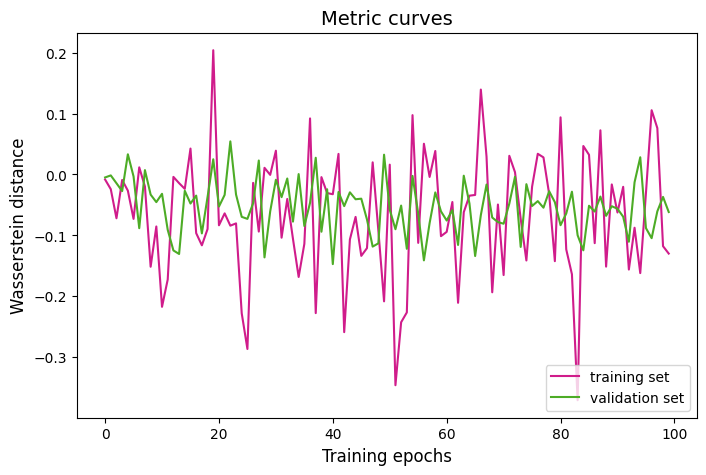

In [35]:
plt.figure(figsize=(8, 5), dpi=100)

plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Wasserstein distance", fontsize=12)
plt.plot(train.history["wass_dist"], color="#d01c8b", label="training set")
plt.plot(train.history["val_wass_dist"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

### Normalizing Flows

#### Architecture of the Flow Model

The flow model in this setup is designed for complex distributions and data transformations. It is composed of several key components:

- **Base Distribution**: The model begins with a base distribution, specifically a standard normal distribution with a shape of `[5]`. This serves as the starting point for generating more complex distributions through a series of transformations.

- **Transformations**:
    - **Random Permutation**: At each layer, a random permutation of the features is applied. This helps in correlating the input data, making the model more flexible.
    - **Masked Affine Autoregressive Transform**: This transform applies an affine transformation $y = Wx + c$, allowing the model to scale and shift the data in a complex, learned manner. The autoregressive property ensures that the transformation of each dimension depends only on the previous dimensions, making the Jacobian of the transform more tractable.
        - The transform uses 3 blocks with 64 hidden features each, and batch normalization is employed to stabilize and speed up training.

- **Composite Transform**: All the individual transforms across layers are combined into a single composite transform. This sequential application of transforms allows the model to learn complex, high-dimensional distributions.

- **Flow Model**: The final model, termed 'flow', uses the composite transform to mold the base distribution into the target distribution. It is capable of both forward and backward operations, crucial for tasks like density estimation and generative modeling.

- **Optimizer**: An Adam optimizer with a learning rate of 0.001 is used to train the model.

The use of autoregressive transforms allows for a powerful and flexible modeling of the data while maintaining computational efficiency.

In [ ]:
from torch import nn
from torch import optim
from scipy import stats
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal,StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform,MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.nn.nets import ResidualNet
from nflows.distributions.normal import ConditionalDiagonalNormal,StandardNormal

#### Preprocessing

In [ ]:
class TrainDataPreprocessor(object):
    def __init__(self, y_train, x_train, scaler_y=None, scaler_x=None, standardize=True):
        """
        Preprocessor for training data.

        :param y_train: Genjet features (originally x_train, but swapped for clarity).
        :param x_train: Recojet features (originally y_train, but swapped for clarity).
        :param scaler_y: Scaler for y_train.
        :param scaler_x: Scaler for x_train.
        :param standardize: Boolean indicating whether to standardize the data.
        """
        self.scaler_y = scaler_y
        self.scaler_x = scaler_x
        self.standardize = standardize
        self.Y = y_train
        self.X = x_train

        # Operations on Y (originally X)
        self.Y[:, 0] = self.Y[:, 0] / self.X[:, 0]
        self.X[:, 4] = np.abs(self.X[:, 4])

        # Smearing of N constituents in Y
        self.Y[:, 3] = self.Y[:, 3] + (0.5 * np.random.uniform(-1, 1, len(self.Y[:, 3])))

        if self.standardize:
            if not self.scaler_y and not self.scaler_x:
                self.scaler_y = StandardScaler()
                self.scaler_y.fit(self.Y)
                self.scaler_x = StandardScaler()
                self.scaler_x.fit(self.X)

            self.Y = self.scaler_y.transform(self.Y)
            self.X = self.scaler_x.transform(self.X)

    def get_dataset(self):
        """
        Get the standardized dataset.

        :return: Tuple of standardized Y and X arrays.
        """
        return self.Y, self.X

    def invert_standardize(self, Y, X):
        """
        Invert the standardization of the dataset.

        :param Y: Standardized genjet features.
        :param X: Standardized recojet features.
        :return: Tuple of original Y and X arrays.
        """
        Y = self.scaler_y.inverse_transform(Y)
        X = self.scaler_x.inverse_transform(X)
        return Y, X

class TestDataPreprocessor(TrainDataPreprocessor):
    """
    Preprocessor for test data, inherits from TrainDataPreprocessor.
    """
    pass

In [ ]:
# Batch size for processing
batch_size = 2000

# Create preprocessors for training and test data
train_dataset = TrainDataPreprocessor(y_train, x_train)
Y_train, X_train = train_dataset.get_dataset()

test_dataset = TestDataPreprocessor(y_test, x_test, scaler_y=train_dataset.scaler_y, scaler_x=train_dataset.scaler_x)
Y_test, X_test = test_dataset.get_dataset()

# Send data to device (e.g., GPU)
X_train = torch.tensor(X_train).float().to(device)
Y_train = torch.tensor(Y_train).float().to(device)

# Invert standardization for test data
Y_test_cpu, X_test_cpu = test_dataset.invert_standardize(Y_test, X_test)
Y_test_cpu[:, 0] = Y_test_cpu[:, 0] * X_test_cpu[:, 0]  # Restore pt distribution

X_test = torch.tensor(X_test).float().to(device)
Y_test = torch.tensor(Y_test).float().to(device)

In [ ]:
print(X_train.shape, Y_train.shape)

#### Define model

In [ ]:
def build_flow():
    num_layers = 10
    base_dist = StandardNormal(shape=[5])
    transforms = []

    # Constructing layers of the flow model
    for _ in range(num_layers):
        transforms.append(RandomPermutation(features=5))
        transforms.append(MaskedAffineAutoregressiveTransform(
            features=5,
            use_residual_blocks=False,
            num_blocks=3,
            hidden_features=64,  # Adjusted from 4, 20 for more capacity
            use_batch_norm=True,
            context_features=5
        ))

    # Combining all transforms into a composite transform
    transform = CompositeTransform(transforms)

    # Creating the flow model with the specified transform and base distribution
    flow = Flow(transform, base_dist)

    # Optimizer for the flow model (LR DEFINED HERE)
    optimizer = optim.Adam(flow.parameters(), lr=0.001)

    return flow, optimizer

# Building the flow model and setting the device
flow, optimizer = build_flow()
flow = flow.to(device)

# Print the number of trainable parameters in the model
print(f"Number of trainable parameters: {sum(p.numel() for p in flow.parameters() if p.requires_grad)}")

In [ ]:
from tqdm import tqdm
start_epoch = 0
epochs=10

batch_size = 2048
scheduler = None

In [ ]:
print(f"Start epoch: {start_epoch} End epoch: {epochs}")
train_history = []
test_history = []

for epoch in range(start_epoch, epochs):
    flow.train()

    # Print learning rate with precision
    for param_group in optimizer.param_groups:
        print_lr = param_group["lr"]
        print(f"Current lr is {print_lr:.8f}")

    train_loss = torch.tensor(0.0).to(device)

    # Loop over batches with a progress bar
    total_batches = (len(Y_train) + batch_size - 1) // batch_size
    with tqdm(total=total_batches, desc="Training", dynamic_ncols=True) as pbar:
        for i in range(0, len(Y_train), batch_size):
            Y_batch = Y_train[i : i + batch_size]
            X_batch = X_train[i : i + batch_size]

            optimizer.zero_grad()
            loss = -flow.log_prob(inputs=Y_batch, context=X_batch).mean()
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix({"Batch Loss": loss.item()})

    train_loss /= total_batches
    train_history.append(train_loss)

    # Test phase
    with torch.no_grad():
        flow.eval()
        test_loss = torch.tensor(0.0).to(device)

        for i in range(0, len(Y_test), batch_size):
            Y_batch = Y_test[i : i + batch_size]
            X_batch = X_test[i : i + batch_size]
            loss = -flow.log_prob(inputs=Y_batch, context=X_batch).mean()
            test_loss += loss.item()

        test_loss /= total_batches
        test_history.append(test_loss)

    if scheduler:
        scheduler.step(train_loss)
    print(f"Epoch: {epoch} Loss: {train_loss}")

In [ ]:
# Plotting the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Training Loss')
plt.plot(test_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Starting sampling")
flow.eval()
samples_list = []

with torch.no_grad():
    with tqdm(total=(len(Y_test) + batch_size - 1) // batch_size, desc="Sampling", dynamic_ncols=True) as pbar:
        for i in range(0, len(Y_test), batch_size):
            X_batch = X_test[i : i + batch_size]  # Getting context batch

            samples = flow.sample(1, context=X_batch)
            samples_list.append(samples.detach().cpu().numpy())
            pbar.update(1)

# Processing the sampled data
samples = np.concatenate(samples_list, axis=0)
samples = samples.reshape((-1, Y_test.shape[1]))
samples = test_dataset.scaler_y.inverse_transform(samples)

# Apply rounding and adjust pt distribution
samples[:, 3] = np.rint(samples[:, 3])
samples[:, 0] = samples[:, 0] * X_test_cpu[:, 0]

# Clipping to physical values based on Y_test_cpu
for i in range(samples.shape[1]):
    samples[:, i] = np.clip(samples[:, i], Y_test_cpu[:, i].min(), Y_test_cpu[:, i].max())

### Validation plots

TBA (add description)

In [ ]:
plot_histograms_and_ratios(samples, Y_test_cpu)

In [ ]:
fig= make_corner(Y_test_cpu, samples, title="correlations") # binning for nConst is broken
fig 

In [36]:
x_test_prep = x_scaler.transform(x_test[:, :-1])  # input pre-processing

int_encoded = label_encoder.transform(x_test[:, -1])
onehot_encoded = onehot_encoder.transform(int_encoded[:, None])  # one-hot encoding

x_test_prep = np.concatenate([x_test_prep, onehot_encoded], axis=1)

In [37]:
gan_out_test_prep = gan.generate(x_test_prep, seed=None).numpy()
gan_out_test_post = y_scaler.inverse_transform(gan_out_test_prep)  # output post-processing

gan_out_test = gan_out_test_post.copy()
gan_out_test[:, :3] += x_test[:, :3]  # from errors to reco vars
gan_out_test[:, 3] = np.round(gan_out_test[:, 3])  # from continous to discrete

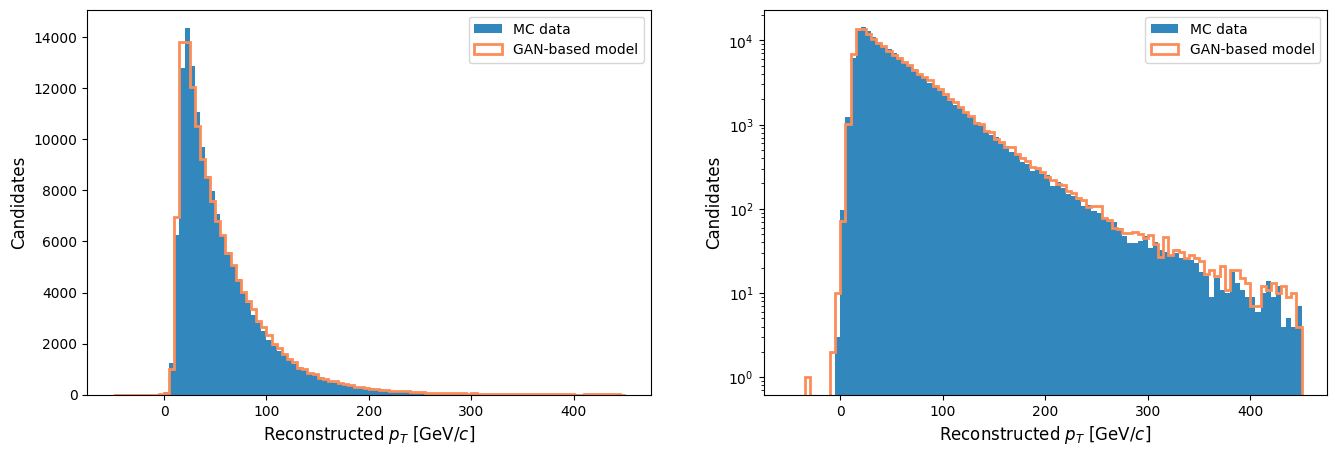

In [38]:
plt.figure(figsize=(16, 5), dpi=100)

bins = np.linspace(-50.0, 450.0, 101)

for i, scale in enumerate(["linear", "log"]):
    plt.subplot(1, 2, i + 1)
    plt.xlabel("Reconstructed $p_T$ [GeV/$c$]", fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_test[:, 0], bins=bins, color="#3288bd", label="MC data")
    plt.hist(gan_out_test[:, 0], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
    plt.legend(loc="upper right", fontsize=10)
    plt.yscale(scale)

plt.show()

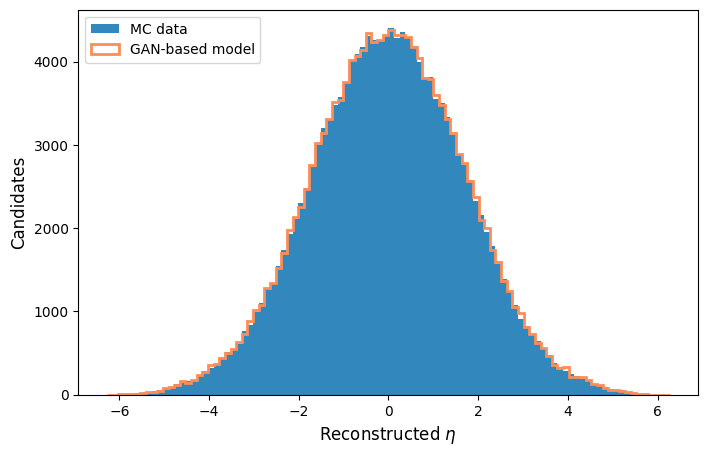

In [39]:
plt.figure(figsize=(8, 5), dpi=100)

bins = np.linspace(-2*np.pi, 2*np.pi, 101)

plt.xlabel(r"Reconstructed $\eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_test[:, 1], bins=bins, color="#3288bd", label="MC data")
plt.hist(gan_out_test[:, 1], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
plt.legend(loc="upper left", fontsize=10)

plt.show()

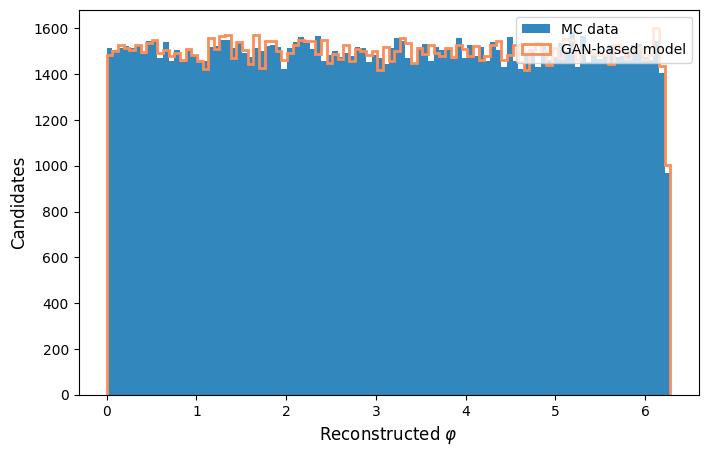

In [40]:
plt.figure(figsize=(8, 5), dpi=100)

bins = np.linspace(0.0, 2*np.pi, 101)

plt.xlabel(r"Reconstructed $\varphi$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_test[:, 2], bins=bins, color="#3288bd", label="MC data")
plt.hist(gan_out_test[:, 2], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
plt.legend(loc="upper right", fontsize=10)

plt.show()

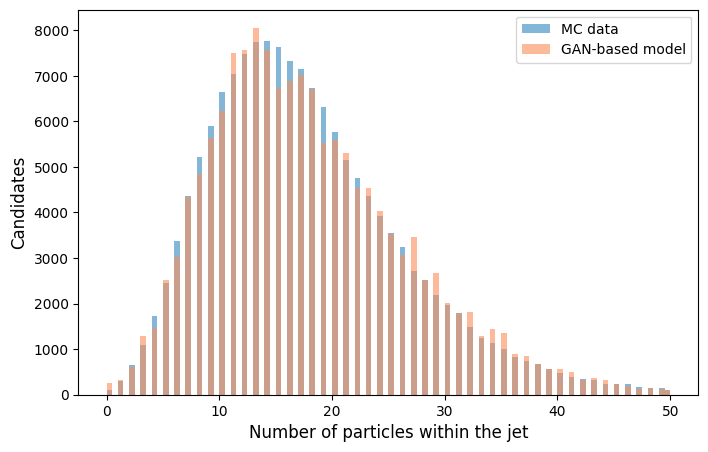

In [41]:
plt.figure(figsize=(8, 5), dpi=100)

bins = np.linspace(0.0, 50.0, 101)

plt.xlabel("Number of particles within the jet", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_test[:, 3], bins=bins, color="#3288bd", alpha=0.6, label="MC data")
plt.hist(gan_out_test[:, 3], bins=bins, color="#fc8d59", alpha=0.6, label="GAN-based model")
plt.legend(loc="upper right", fontsize=10)

plt.show()

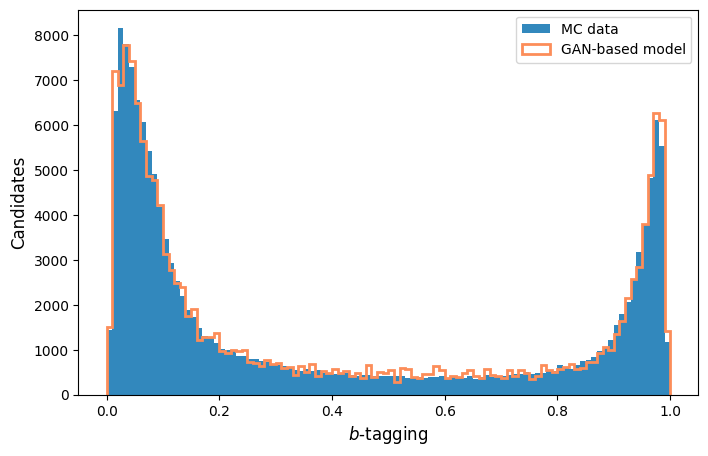

In [42]:
plt.figure(figsize=(8, 5), dpi=100)

bins = np.linspace(0.0, 1.0, 101)

plt.xlabel("$b$-tagging", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_test[:, 4], bins=bins, color="#3288bd", label="MC data")
plt.hist(gan_out_test[:, 4], bins=bins, histtype="step", lw=2, color="#fc8d59", label="GAN-based model")
plt.legend(loc="upper right", fontsize=10)

plt.show()

## References

1. I.J. Goodfellow _et al._, "Generative Adversarial Networks", [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
2. M. Arjovsky, L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862](https://arxiv.org/abs/1701.04862)
3. X. Mao _et al._, "Least Squares Generative Adversarial Networks", [arXiv:1611.04076](https://arxiv.org/abs/1611.04076)
4. M. Arjovsky, S. Chintala, L. Bottou, "Wasserstein GAN", [arXiv:1701.07875](https://arxiv.org/abs/1701.07875)
5. I. Gulrajani _et al._, "Improved Training of Wasserstein GANs", [arXiv:1704.00028](https://arxiv.org/abs/1704.00028)
6. M.G. Bellemare _et al._, "The Cramer Distance as a Solution to Biased Wasserstein Gradients", [arXiv:1705.10743](https://arxiv.org/abs/1705.10743)
7. D. Terjék, "Adversarial Lipschitz Regularization", [arXiv:1907.05681](https://arxiv.org/abs/1907.05681)
8. T. Salimans _et al._, "Improved Techniques for Training GANs", [arXiv:1606.03498](https://arxiv.org/abs/1606.03498)
9. M. Mirza, S. Osindero, "Conditional Generative Adversarial Nets", [arXiv:1411.1784](https://arxiv.org/abs/1411.1784)

## Credits
This hands-on is based on the tutorials provided by the [pidgan](https://github.com/mbarbetti/pidgan) package.